In [3]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models, regularizers, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# إعدادات لضمان تكرار النتائج
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries Imported Successfully.")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Libraries Imported Successfully.
Num GPUs Available:  0


هنا هكتب ال Data loader 


In [4]:
# ================= CONFIG (تأكد من صحة هذه المسارات) =================
# 1. المسار الرئيسي اللي جواه فولدرات الكلمات (dog, cat, etc.)
LOCAL_DATA_DIR = r"/mnt/Hub_1/Mix/Projects/Graduation -Project/Data/1st_prototype_processed_2"

# 2. ملف CSV لاستخراج أسماء الكلمات وعمل الـ Label Map
ANY_CSV_WITH_WORDS = r"/mnt/Hub_1/Mix/Projects/Graduation -Project/Data/mini_dataset.csv"

# 3. ملفات تقسيم الداتا (Train / Val)
TRAIN_CSV_PATH = r"/mnt/Hub_1/Mix/Projects/Graduation -Project/Data/prototype_train.csv"
VAL_CSV_PATH   = r"/mnt/Hub_1/Mix/Projects/Graduation -Project/Data/prototype_val.csv"

# 4. مكان حفظ ملف القاموس
LABEL_MAP_OUTPUT = r"/mnt/Hub_1/Mix/Projects/Graduation -Project/Data/label_map.json"


# ================= Generate Label Map =================
if not os.path.exists(LABEL_MAP_OUTPUT):
    print("⚠️ Label map not found. Generating it now...")
    if os.path.exists(ANY_CSV_WITH_WORDS):
        df = pd.read_csv(ANY_CSV_WITH_WORDS)
        unique_words = sorted(df['word'].unique())
        label_map = {word: i for i, word in enumerate(unique_words)}
        
        with open(LABEL_MAP_OUTPUT, 'w') as f:
            json.dump(label_map, f, indent=4)
        print(f"✅ Created label_map.json with {len(label_map)} classes.")
    else:
        raise FileNotFoundError("❌ CSV file for labels not found!")
else:
    print("✅ Label map already exists.")

# تحميل القاموس
with open(LABEL_MAP_OUTPUT, 'r') as f:
    label_map = json.load(f)

NUM_CLASSES = len(label_map)
print(f"Loaded {NUM_CLASSES} classes.")


# ================= Data Generator Class =================
class DataGenerator(Sequence):
    def __init__(self, csv_path, base_data_dir, batch_size=32, num_classes=100, shuffle=True, label_map=None):
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.label_map = label_map
        self.base_data_dir = base_data_dir
        
        # قراءة الـ CSV
        self.df = pd.read_csv(csv_path)
        
        # تحميل البيانات في الرام
        print(f"🔄 Pre-loading data from {os.path.basename(csv_path)} into RAM...")
        self.X_data = []
        self.y_data = []
        
        loaded_count = 0
        
        for i in range(len(self.df)):
            row = self.df.iloc[i]
            word = row['word']
            
            # معالجة اسم الملف بمرونة
            # لو العمود اسمه full_path أو videos
            col_name = 'full_path' if 'full_path' in row else 'videos'
            video_path_raw = row[col_name]
            
            # استخراج اسم الفيديو فقط بدون المسار القديم
            video_name = os.path.basename(video_path_raw)
            # تغيير الامتداد لـ .npy
            npy_name = os.path.splitext(video_name)[0] + '.npy'
            
            # تكوين المسار الجديد بناءً على الفولدر المحلي لديك
            # الهيكلية المتوقعة: base_dir / word / file.npy
            npy_path = os.path.join(self.base_data_dir, word, npy_name)
            
            if os.path.exists(npy_path):
                try:
                    data = np.load(npy_path)
                    # التأكد من الأبعاد (50 فريم، 198 نقطة)
                    if data.shape == (50, 198): 
                        self.X_data.append(data)
                        self.y_data.append(self.label_map[word])
                        loaded_count += 1
                except Exception as e:
                    print(f"Error loading {npy_path}: {e}")
        
        # تحويل القوائم إلى مصفوفات Numpy
        self.X_data = np.array(self.X_data, dtype=np.float32)
        self.y_data = np.array(self.y_data, dtype=np.int32)
        
        self.n_samples = len(self.X_data)
        self.indexes = np.arange(self.n_samples)
        
        print(f"✅ Successfully loaded {self.n_samples} samples.")
        
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(self.n_samples / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        X_batch = self.X_data[indexes]
        y_batch = self.y_data[indexes]
        
        y_encoded = tf.keras.utils.to_categorical(y_batch, num_classes=self.num_classes)
        return X_batch, y_encoded

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

✅ Label map already exists.
Loaded 100 classes.


In [8]:
# Cell 4: Model Architecture & Build

# ==========================================
# 1. تعريف شكل الدخل يدوياً (لحل مشكلة NameError)
# ==========================================
INPUT_SHAPE = (50, 198)  # (Frames, Landmarks)

# التأكد من أن NUM_CLASSES معرف أيضاً
if 'NUM_CLASSES' not in locals():
    # في حالة لم يتم تعريفه، نأخذه من طول الـ label_map
    NUM_CLASSES = len(label_map) 

print(f"Building model with Input Shape: {INPUT_SHAPE} and {NUM_CLASSES} Classes")


def build_coupled_gru(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Masking
    x = layers.Masking(mask_value=0.0)(inputs)

    # Bi-GRU 1
    x = layers.Bidirectional(
        layers.GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.0)
    )(x)
    x = layers.BatchNormalization()(x)

    # Bi-GRU 2
    x = layers.Bidirectional(
        layers.GRU(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.0)
    )(x)
    x = layers.BatchNormalization()(x)

    # Attention
    attn = layers.MultiHeadAttention(num_heads=4, key_dim=64, dropout=0.2)(x, x)
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    # Hybrid Pooling
    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)
    x = layers.Concatenate()([avg_pool, max_pool])

    # Dense Head
    x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs, name="ASL_Coupled_BiGRU")

# ==========================================
# 3. بناء وتجميع الموديل
# ==========================================
model = build_coupled_gru(INPUT_SHAPE, NUM_CLASSES)

model.compile(
    optimizer=optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4),
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
)

model.summary()

Building model with Input Shape: (50, 198) and 100 Classes


/home/abdulrahman-mohamed-rizk/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "ASL_Coupled_BiGRU"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 198)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 50, 198)   │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 50, 198)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 50)        │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50, 256)   │    251,904 │ masking[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 50, 256)   │      1,024 │ bidirectional[0]… │
│ (BatchNormalizatio… │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 50, 128)   │    123,648 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 128)   │        512 │ bidirectional_1[… │
│ (BatchNormalizatio… │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 50, 128)   │    131,968 │ batch_normalizat… │
│ (MultiHeadAttentio… │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 50, 128)   │          0 │ batch_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 50, 128)   │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logical_or          │ (None, 50)        │          0 │ any[0][0],        │
│ (LogicalOr)         │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │ logical_or[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     65,792 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat

 Total params: 601,828 (2.30 MB)

 Trainable params: 600,548 (2.29 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [ ]:
# Cell 3: Initialize Generators
# ==========================================
# هذه الخطوة مهمة جداً لتعريف train_gen و val_gen
# ==========================================

BATCH_SIZE = 32  # يمكنك تقليله لـ 16 لو الرامات عندك اتملت


if 'DataGenerator' not in locals() or 'TRAIN_CSV_PATH' not in locals():
    print(" Run DataGenerator first ")
else:
    print("🚀 Initializing Data Generators...")

    # 1. Training Generator
    print("\n--- Loading Training Data ---")
    train_gen = DataGenerator(
        csv_path=TRAIN_CSV_PATH,    # تأكد أن هذا المتغير معرف في Cell 2
        base_data_dir=LOCAL_DATA_DIR,
        batch_size=BATCH_SIZE,
        num_classes=NUM_CLASSES,
        shuffle=True,
        label_map=label_map
    )

    # 2. Validation Generator
    print("\n--- Loading Validation Data ---")
    val_gen = DataGenerator(
        csv_path=VAL_CSV_PATH,      
        base_data_dir=LOCAL_DATA_DIR,
        batch_size=BATCH_SIZE,
        num_classes=NUM_CLASSES,
        shuffle=False,
        label_map=label_map
    )

    print("\n✅ Generators are ready!")
    print(f"Training Batches per Epoch: {len(train_gen)}")
    print(f"Validation Batches per Epoch: {len(val_gen)}")
    

🚀 Initializing Data Generators...

--- Loading Training Data ---
🔄 Pre-loading data from prototype_train.csv into RAM...
✅ Successfully loaded 8916 samples.

--- Loading Validation Data ---
🔄 Pre-loading data from prototype_val.csv into RAM...
✅ Successfully loaded 1115 samples.

✅ Generators are ready!
Training Batches per Epoch: 278
Validation Batches per Epoch: 34


In [12]:
callbacks_list = [
    callbacks.EarlyStopping(
        monitor="val_accuracy", patience=15, restore_best_weights=True, verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1
    ),
    callbacks.ModelCheckpoint(
        "best_asl_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1
    )
]

print(">>> Starting Training...")

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=150, # عدل الرقم براحتك
    callbacks=callbacks_list
)

>>> Starting Training...


/home/abdulrahman-mohamed-rizk/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.0173 - loss: 5.4126
Epoch 1: val_accuracy improved from -inf to 0.07445, saving model to best_asl_model.keras
278/278 ━━━━━━━━━━━━━━━━━━━━ 44s 110ms/step - accuracy: 0.0173 - loss: 5.4113 - val_accuracy: 0.0744 - val_loss: 4.1814 - learning_rate: 0.0010
Epoch 2/150
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.0579 - loss: 4.3122
Epoch 2: val_accuracy improved from 0.07445 to 0.11305, saving model to best_asl_model.keras
278/278 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - accuracy: 0.0580 - loss: 4.3118 - val_accuracy: 0.1131 - val_loss: 3.6611 - learning_rate: 0.0010
Epoch 3/150
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.1062 - loss: 3.9017
Epoch 3: val_accuracy improved from 0.11305 to 0.18750, saving model to best_asl_model.keras
278/278 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - accuracy: 0.1062 - loss: 3.9013 - val_accuracy: 0.1875 - val_loss: 3.3710 - learning_rate: 0.0010
Epoch 4/150
278/278 ━━━━━

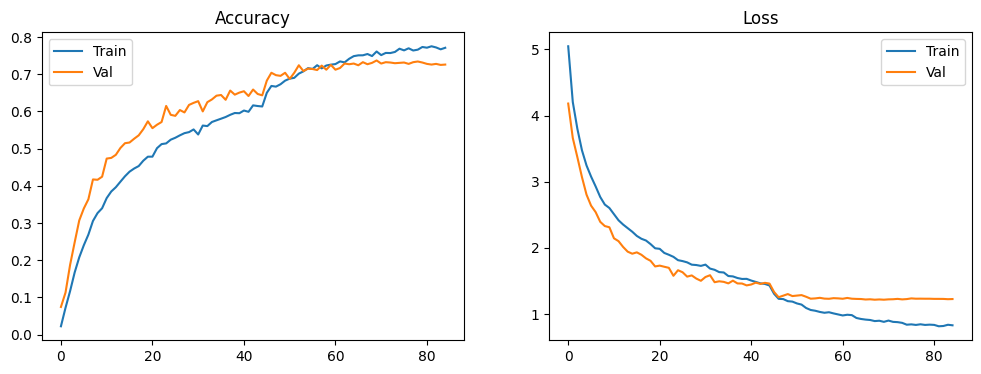


>>> Generating Confusion Matrix on Validation Data...
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step
              precision    recall  f1-score   support

      animal       0.60      0.60      0.60        10
         arm       0.90      0.82      0.86        11
      arrest       0.78      0.70      0.74        10
        baby       0.53      0.80      0.64        10
      banana       0.80      0.86      0.83        14
        bark       0.62      1.00      0.77        10
  basketball       0.91      0.91      0.91        11
         bat       0.89      0.80      0.84        10
         bow       0.73      0.67      0.70        12
         bra       1.00      0.80      0.89        10
       break       0.43      0.30      0.35        10
        bury       0.85      0.85      0.85        13
        call       0.67      0.67      0.67         9
       candy       0.88      0.70      0.78        10
      carrot       0.73      1.00      0.85        11
      castle       0.91      0.83      0

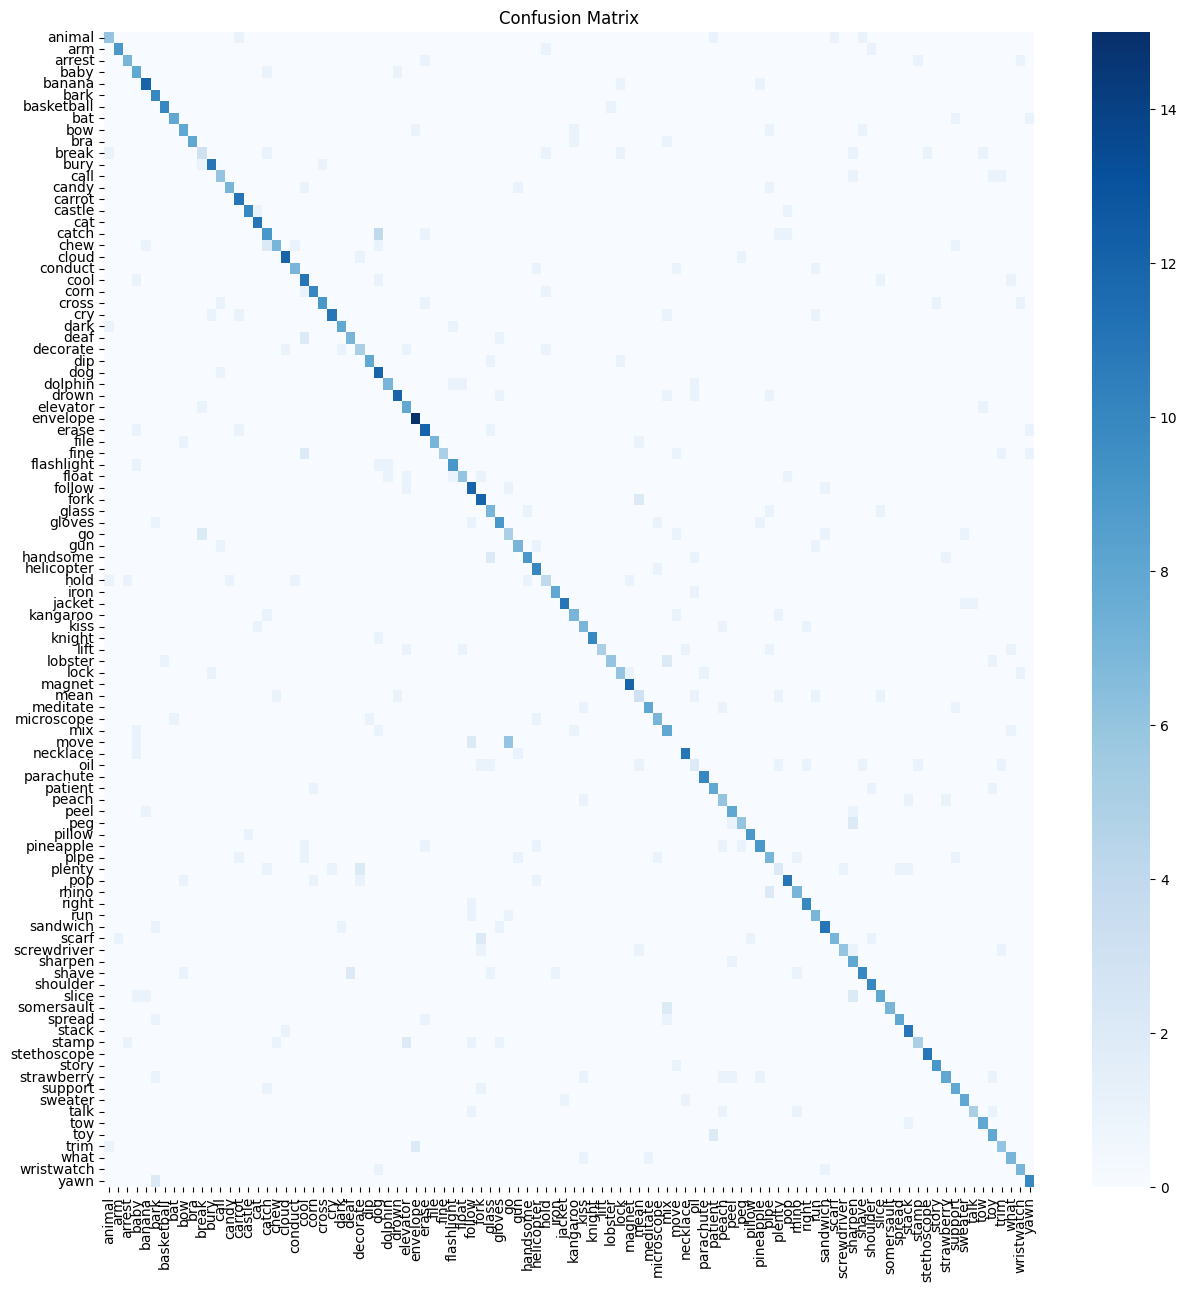

In [13]:
# 1. Plot Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy'); plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss'); plt.legend()
plt.show()

# 2. Evaluation on Validation Set
print("\n>>> Generating Confusion Matrix on Validation Data...")

# استخراج الداتا الخام من الـ Generator (لأننا حملناها في الرام)
X_val_all = val_gen.X_data
y_val_true = val_gen.y_data # هذه الأرقام الصحيحة (Integer)

# التوقع
y_pred_probs = model.predict(X_val_all)
y_pred = np.argmax(y_pred_probs, axis=1)

# ترتيب الأسماء للعرض
inv_label_map = {v: k for k, v in label_map.items()}
class_names_ordered = [inv_label_map[i] for i in range(NUM_CLASSES)]

# Classification Report
print(classification_report(y_val_true, y_pred, target_names=class_names_ordered))

# Confusion Matrix
plt.figure(figsize=(15, 15))
cm = confusion_matrix(y_val_true, y_pred)
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_names_ordered, yticklabels=class_names_ordered)
plt.title("Confusion Matrix")
plt.show()